In [1]:
import os
import numpy as np
import geopandas as gpd
import shapely as shp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
from datetime import datetime
from glob import glob

In [2]:
# Params
data_dir = os.path.join(os.path.join(os.getcwd(),"shared_data")) # Path to sea level CSVs
plot_dir = os.path.join(os.getcwd(),"figures/plots")
station_file_name = "qui-nong" # Name of sea level csv
station = "Qui Nhong" # name of station 

# global Plotting params
#rc('text', usetex=True)
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["font.size"] = 11
coastal_blue = "#074e67"
coastal_turquoise = "#05878a"
coastal_beige = "#b6af9d"
coastal_orange = "#ff8f7a"
coastal_grey = "#d7ccc8"

In [3]:
# some useful functions, might be outsourced later! 
def sea_level_prep(station_data):
    #read and clean sea level station data 
    station_data.columns = ['year','month','day','hour','sea_level'] # name columns
    station_data = station_data[station_data.sea_level >= 0] # remove all rows with sea level smaller zero
    return station_data

def get_valid_years(station_data):
    # remove entries with more than a third missing values
    year_values = dict(station_data.year.value_counts())
    for key, value in dict(year_values).items():
            if value < 24*365/3:
                del year_values[key]
    years = list(year_values.keys())
    years.sort()
    print('Sea level station data available for the years',years,'at Station',station,',Vietnam.\n')
    return years

def rounder(time):
    # round time to nearest hour
    if time.minute >= 30:
        return time.replace(second=0, microsecond=0, minute=0, hour=time.hour+1)
    else:
        return time.replace(second=0, microseconfigd=0, minute=0)

In [4]:
# read and clean sea level station data
sl_station_data  = pd.read_csv(os.path.join(data_dir,'sea_level_data',station_file_name+".csv")) # read csv
sl_station_data = sea_level_prep(sl_station_data)
sl_station_data['date'] = pd.to_datetime(sl_station_data[['year', 'month', 'day', 'hour']])
sl_station_data['doy'] = [datetime.date(d).timetuple().tm_yday for d in sl_station_data.date]
# create a list of years for which sea level data is available 
years = get_valid_years(sl_station_data)

Sea level station data available for the years [1994, 1995, 1996, 2000, 2003, 2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] at Station Qui Nhong ,Vietnam.



In [9]:
# read landsat aquisition data for 2008 from Qui Nong 
ls_files = glob(os.path.join(data_dir,"QuiNhon*.csv"))
ls_files.sort()

for file in ls_files: 
    year = int(os.path.basename(file)[7:11])
    print(year)
    data1 = sl_station_data[sl_station_data.year==year].reset_index(drop=True)
    print(np.percentile(data1.sea_level,75))
    

1996
1770.0
2008
1720.0
2015
1623.0


1996
1600.0
2008
1522.5
2015
1578.0


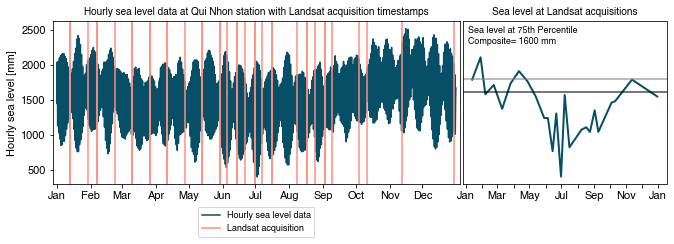

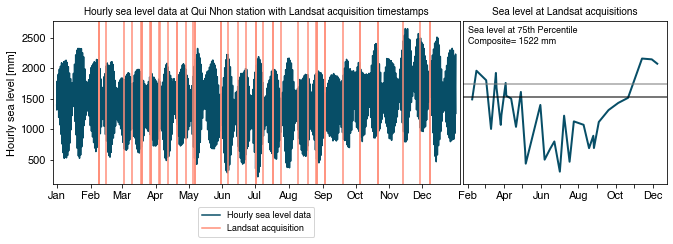

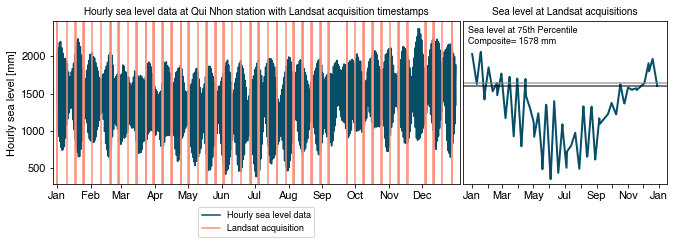

In [44]:
# read landsat aquisition data for 2008 from Qui Nong 
ls_files = glob(os.path.join(data_dir,"QuiNhon*.csv"))
ls_files.sort()

for file in ls_files: 
    year = int(os.path.basename(file)[7:11])
    print(year)
    data1 = sl_station_data[sl_station_data.year==year].reset_index(drop=True)

    data2 = pd.read_csv(file)
    data2 = data2.drop(columns=['system:index','.geo'])
    data2 = data2.transpose().rename(columns={0:"date"})
    data2 = data2.sort_values(by="date").reset_index(drop=True)
    data2['date'] = pd.to_datetime(data2.date)
    data2['date'] = [rounder(date) for date in data2.date]
    data2['doy'] = [datetime.date(d).timetuple().tm_yday for d in data2.date]

    ls_sea_levels = []
    for date in data2.date: 
        ls_sea_level = data1[data1.date == date]
        ls_sea_level = int(ls_sea_level.sea_level)
        ls_sea_levels.append(ls_sea_level)
    data2['sea_level'] = ls_sea_levels
    
    print(np.percentile(data2.sea_level,75))
    
    # plot sea level for one year with Landsat aquistion dates    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,3), gridspec_kw={'width_ratios': [2, 1]})
    ax1.plot(data1.date,data1.sea_level,color=coastal_blue,label="Hourly sea level data")
    ax1.axvline(data2.date.iloc[0],label="Landsat acquisition",color=coastal_orange)
    ax1.set_ylabel("Hourly sea level [mm]")
    xcoords = list(data2.date)
    for xc in xcoords:
        ax1.axvline(x=xc,color=coastal_orange)
    ax1.margins(x=0.01)
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))    #ax1.set_xticks(ax.get_xticks()[0:-1])
    ax1.xaxis.get_major_ticks()[-1].draw = lambda *args:None
    ax1.set_title("Hourly sea level data at Qui Nhon station with Landsat acquisition timestamps",fontsize=10)
    ax1.get_legend_handles_labels()
    lgd = ax1.legend(fontsize=9,loc="lower center",bbox_to_anchor=[0.5,-0.35])

    ax2.plot(data2.date,data2.sea_level,color=coastal_blue, label= "Landast acquisition", lw=2)
    ax2.set_ylim(min(data1.sea_level),max(data1.sea_level))
    ax2.yaxis.set_visible(False)fig
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    for label in ax2.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)
    ax2.axhline(np.percentile(data1.sea_level,75),color="grey",alpha=0.7)
    ax2.axhline(np.percentile(data2.sea_level,75),color="black",alpha=0.7)
    ax2.annotate("Sea level at 75th Percentile \nComposite= "+str(int(np.percentile(data2.sea_level,75)))+" mm",
        fontsize=9,
        xy=(0,1),
        xycoords="axes fraction",
        xytext=(5,-5), 
        textcoords="offset points",ha="left",va="top")
    ax2.set_title("Sea level at Landsat acquisitions",fontsize=10)

    fig.subplots_adjust(wspace=0.01, hspace=0)
    fig.tight_layout
    #fig.savefig(os.path.join(plot_dir,str(year)), bbox_inches='tight',dpi=300)

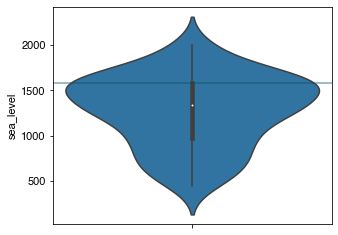

In [43]:
# plotting landsat sea levels as violin (not implemented)
fig, ax = plt.subplots(figsize = (5,4))
sns.violinplot(y=data2.sea_level,data=data2)
ax.axhline(np.percentile(data2.sea_level,75),color=coastal_blue,alpha=0.5)